In [1]:
import matplotlib.pyplot as plt
import warnings
import joblib
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
X_train, y_train, X_test, y_test = joblib.load('data_FAA/data.pkl')
redo_grid_search = 0
cm = 0

In [4]:
if redo_grid_search:
  PARAMETERS = {'learning_rate': [0.01, 1.0],
                'num_leaves': [24, 80],
                'feature_fraction': [0.1, 0.9],
                'bagging_fraction': [0.8, 1],
                'max_depth': [5, 30],
                'max_bin':[20,90, 250, 500],
                'min_data_in_leaf': [20, 80],
                'min_sum_hessian_in_leaf':[0,100],
                'subsample': [0.01, 1.0],
                "boosting_type": ["dart", "gbdt", "goos"]}

  # HalvingGridSearchCV
  grid_search_lbg = HalvingGridSearchCV(estimator=lgb.LGBMClassifier(),param_grid=PARAMETERS,verbose = 1,
                                                            cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                            resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

  lbg_best = grid_search_lbg.best_estimator_
  print("LGBM Classifer")
  print('LGBM Classifer Best Score',grid_search_lbg.best_score_)
  print('LGBM Classifer Best Parmas',grid_search_lbg.best_params_)
  print('LGBM Classifer Accuracy',cross_val_score(lbg_best,X_train.values, y_train.values.ravel(), cv=10).mean())
else:
  lbg_best = lgb.LGBMClassifier()

In [5]:
y_pred = cross_val_predict(lbg_best, X_train, y_train, cv=20)

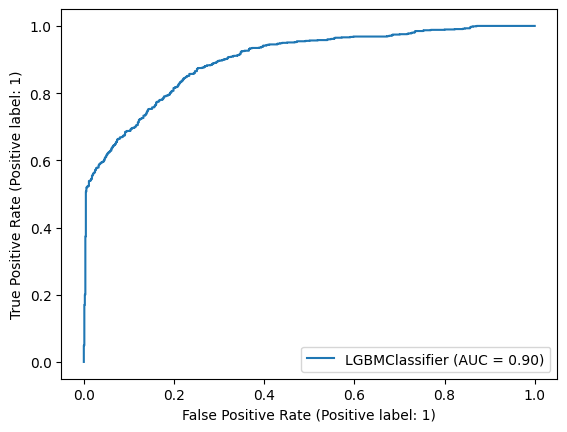

In [6]:
from sklearn.metrics import RocCurveDisplay
lbg_best.fit(X_train, y_train)
RocCurveDisplay.from_estimator(
   lbg_best, X_test, y_test)


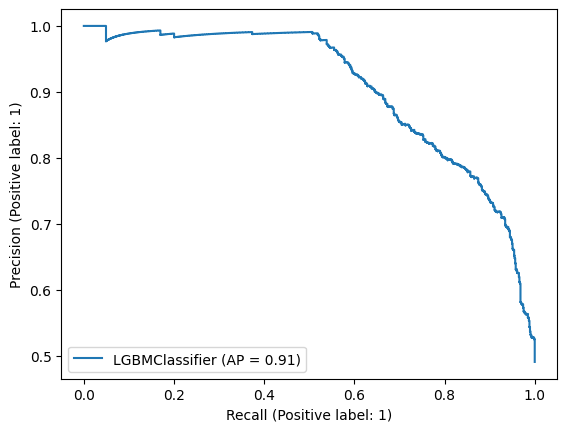

In [7]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(
   lbg_best, X_test, y_test)

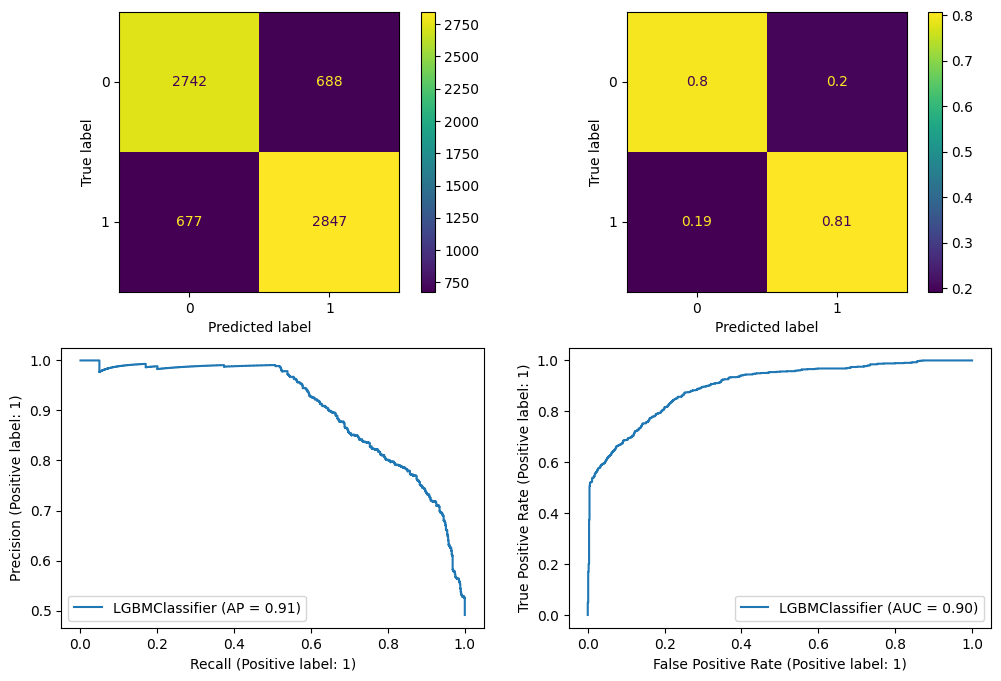

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
RocCurveDisplay.from_estimator(
   lbg_best, X_test, y_test, ax=ax[1, 1])


PrecisionRecallDisplay.from_estimator(
   lbg_best, X_test, y_test, ax=ax[1, 0])

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, ax=ax[0, 0])
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize="true", ax=ax[0, 1])
plt.show()

In [9]:
%%time

# always use same RANDOM_STATE k-folds for comparability between tests, reproducibility
RANDOMSTATE = 42
np.random.seed(RANDOMSTATE)

kfolds = KFold(n_splits=20, shuffle=True, random_state=RANDOMSTATE)

MEAN_RESPONSE=y_train.mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)
	
scores = -cross_val_score(lbg_best, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

Raw CV RMSE 1 (STD 0)
CPU times: user 150 ms, sys: 167 ms, total: 317 ms
Wall time: 8.93 s


In [13]:
max_scores = sum(score for score, name in zip(lbg_best.feature_importances_, X_train.columns))

for score, name in zip(lbg_best.feature_importances_, X_train.columns):
    print(f"{score/max_scores * 100:.1f}%{' ':>20}{name.split('__', 1)[1]:>20}")

7.0%                             RoomService
8.1%                               FoodCourt
6.9%                            ShoppingMall
9.3%                                     Spa
8.9%                                  VRDeck
12.8%                             CabinNumber
2.7%                              HomePlanet
1.4%                               CryoSleep
1.9%                             Destination
0.2%                                     VIP
11.2%                                   Group
2.0%                                Group_id
11.9%                                 Surname
6.8%                                    Deck
3.2%                               CabinSide
4.3%                                     age
1.5%                                   total


In [11]:
train_sizes, train_scores, valid_scores = learning_curve(
    lbg_best, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
# plt.axis([0, 1000, 0.3, 0.9])
# plt.save_fig("underfitting_learning_curves_plot")

plt.show()

KeyboardInterrupt: 

In [ ]:
def pandas_preprocessing(X, y_present=True):
  X['PassengerId_split'] = X['PassengerId'].apply(lambda x : str(x).split(sep = '_', maxsplit=1))
  X['Group']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['Group_id']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['PassengerId','PassengerId_split'],axis=1)

  # Split the names
  X['Name_split'] = X['Name'].apply(lambda x : str(x).split(sep = ' ', maxsplit=1))
  X['Surname']= X['Name_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['Name','Name_split'],axis=1)

  # Split the cabins
  X['Cabin_splt'] = X['Cabin'].apply(lambda x : str(x).split(sep = '/'))
  X['Deck']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['CabinNumber']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[1]).astype('float')
  X['CabinSide']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[2])
  X = X.drop(['Cabin','Cabin_splt'],axis=1)

  # Create Total
  numeric_cols = list(X.select_dtypes(include = np.number).columns)
  X['Total'] = sum(X[col] for col in numeric_cols if col not in ["Age", "CabinNumber"])
  X['age'] = pd.cut(x=X['Age'], bins=range(0, 90, 10))
  X['total'] = pd.cut(x=X['Total'], bins=[-35.987, 3598.7, 7197.4, 10796.1, 14394.8, 17993.5, 21592.2, 25190.9, 28789.6, 32388.3, 35987.])
  X = X.drop(['Age', "Total"],axis=1)
  X['age'] = X['age'].astype('str') 
  X['total'] = X['total'].astype('str')
  target = X['Transported']
  target = target.astype(int)
  X = X.drop(['Transported'],axis=1)
  return X, target

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer


warnings.filterwarnings('ignore')

In [ ]:
bol_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    )


num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (bol_pipeline, make_column_selector(dtype_include=bool)),
)

In [ ]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2['Transported'] =-1

data1, y1 = pandas_preprocessing(data1)
data2, y2 = pandas_preprocessing(data2)

data1 = preprocessing.fit_transform(data1)
data2 = preprocessing.transform(data2)

lbg_best.fit(data1, y1)

pred = lbg_best.predict(data2)

pred = pred.astype(bool)
result=pd.read_csv('data_FAA/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submission_lbgm.csv', index=False)